# RNN

*Recurent Neural Network*

再帰型ニューラルネットワーク。  
再帰的な構造を持つニューラルネットワークで、可変長の時系列データを扱うことができる。

このモデルは入力$x_t$に対して以下のような演算を行い、出力値$h_t$を求める。

$$
h_t = \mathrm{tanh}(W_x x_t + b_x + W_h h_{t-1} + b_h)
$$

これをそのまま使うこともできるし、1つの層としてNNの中に組み込むこともできる。

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


---

## Inprementation

- [RNN — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

In [2]:
input_size, output_size = 3, 2
rnn = nn.RNN(input_size, output_size)

In [3]:
for params in rnn.parameters():
    print(params.shape)

torch.Size([2, 3])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2])


In [4]:
sequence_length, batch_size = 5, 4
x = torch.randn(sequence_length, batch_size, input_size)
x.shape

torch.Size([5, 4, 3])

In [5]:
y, h = rnn(x)
y.shape, h.shape

(torch.Size([5, 4, 2]), torch.Size([1, 4, 2]))

In [6]:
rnn = nn.RNN(input_size, output_size, batch_first=True)
x = torch.randn(batch_size, sequence_length, input_size)
x.shape

torch.Size([4, 5, 3])

In [7]:
y, h = rnn(x)
y.shape, h.shape

(torch.Size([4, 5, 2]), torch.Size([1, 4, 2]))


---

## sin波予測

RNNをモデルに組み込んでsin波を予測する

## Dataset

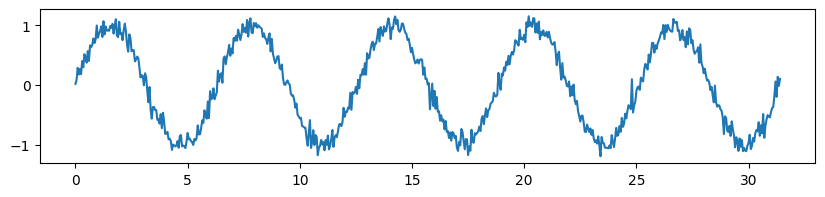

In [8]:
t = torch.arange(0, 10*torch.pi, 0.05)
y = torch.sin(t)
y.add_(torch.randn_like(y) * 0.1)
plt.figure(figsize=(10, 2))
plt.plot(t, y);

こんな感じの、ノイズの入ったsin波を学習データとする。

系列長は適当に100とする。固定。

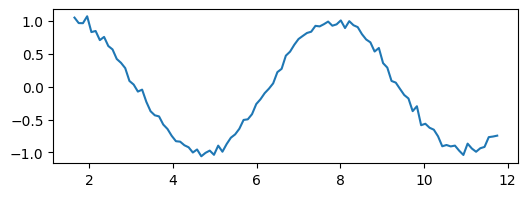

In [9]:
length = 100
n_samples = 10000
step_size = 0.1
noize_srd = 0.05

start = np.random.rand(n_samples) * 2 * np.pi
t = np.linspace(start, start + step_size * (length + 1), length + 1).T
samples = torch.sin(torch.tensor(t)).to(torch.float32)
samples.add_(torch.randn_like(samples) * noize_srd)
plt.figure(figsize=(6, 2))
plt.plot(t[0], samples[0]);

In [10]:
samples.shape

torch.Size([10000, 101])

In [11]:
x = samples[:, :-1].unsqueeze(-1)
y = samples[:, 1:].unsqueeze(-1)
x.shape, y.shape

(torch.Size([10000, 100, 1]), torch.Size([10000, 100, 1]))

In [12]:
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### モデル構築

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        y, _ = self.rnn(x)
        y = self.fc(y)
        return y

    @torch.no_grad()
    def gen_seq(self, seq_len, x=None):
        model.eval()
        x.unsqueeze_(0)
        x = x if x != None else torch.zeros(1, 1, self.input_size)
        _, h = self.rnn(x)
        y = self.fc(h)

        seq = [y.item()]
        for _ in range(seq_len - 1):
            _, h = self.rnn(y, h)
            y = self.fc(h)
            seq.append(y.item())

        return torch.tensor(seq)

### 学習

In [14]:
criterion = nn.MSELoss()
def train(model, n_epochs, optimizer):
    model.train()
    for epoch in range(1, n_epochs + 1):
        for x, y in tqdm(dataloader, desc=f'Epoch {epoch}/{n_epochs}'):
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        print('    loss:', loss.item())

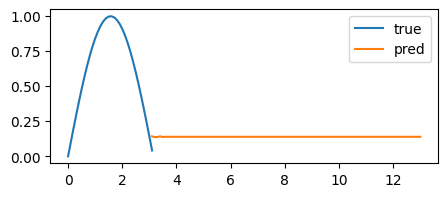

In [15]:
model = RNN(1, 32, 1)

t = torch.arange(0, torch.pi, step_size)
y = torch.sin(t)
pred_y = model.gen_seq(100, y.unsqueeze(-1))
t_pred = torch.arange(0, step_size * len(pred_y), step_size) + t[-1]
plt.figure(figsize=(5, 2))
plt.plot(t, y, label='true')
plt.plot(t_pred, pred_y, label='pred')
plt.legend();

In [16]:
model = RNN(1, 16, 1)
optimizer = optim.Adam(model.parameters())
train(model, 5, optimizer)

Epoch 1/5: 100%|██████████| 313/313 [00:01<00:00, 289.16it/s]


    loss: 0.010420952923595905


Epoch 2/5: 100%|██████████| 313/313 [00:01<00:00, 294.99it/s]


    loss: 0.006857993546873331


Epoch 3/5: 100%|██████████| 313/313 [00:01<00:00, 294.81it/s]


    loss: 0.006066364236176014


Epoch 4/5: 100%|██████████| 313/313 [00:01<00:00, 295.07it/s]


    loss: 0.005707783158868551


Epoch 5/5: 100%|██████████| 313/313 [00:01<00:00, 295.02it/s]

    loss: 0.005450820550322533


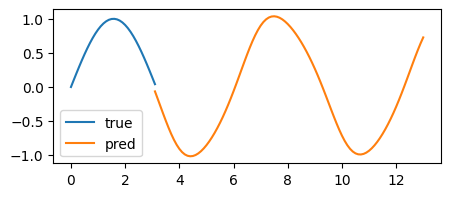

In [17]:
t = torch.arange(0, torch.pi, step_size)
y = torch.sin(t)
pred_y = model.gen_seq(100, y.unsqueeze(-1))
t_pred = torch.arange(0, step_size * len(pred_y), step_size) + t[-1]
plt.figure(figsize=(5, 2))
plt.plot(t, y, label='true')
plt.plot(t_pred, pred_y, label='pred')
plt.legend();